#HACKATHON EVENT-16/02/2023

PROJECT IDEA: SENTIMENTAL ANALYSIS OF TWITTER TWEETS

TEAM MEMBERS

2041122 SUNAY P

2041141 AMULYA HM

2041147 KOUSIKA R

2041149 MALASREE C

# LIBRARIES

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.feature_extraction.text import CountVectorizer

import gensim

import re
from wordcloud import WordCloud
import nltk

from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence

#Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/Machine Learning/train_tweet.csv')
test = pd.read_csv('/content/drive/MyDrive/Machine Learning/test_tweets.csv')

print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


# Preprocessing and Cleaning of Data

In [5]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [7]:
train.isnull().any()
test.isnull().any()

id       False
tweet    False
dtype: bool

In [8]:
train.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [9]:
# checking out the negative comments from the train set

train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [10]:
# checking out the postive comments from the train set 

train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


Text(0.5, 1.0, 'COUNT OF POSITIVE AND NEGATIVE TWEETS')

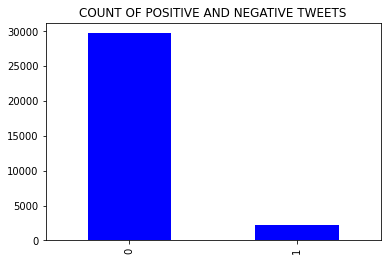

In [11]:
train['label'].value_counts().plot.bar(color = 'blue', figsize = (6, 4))
plt.title("COUNT OF POSITIVE AND NEGATIVE TWEETS")

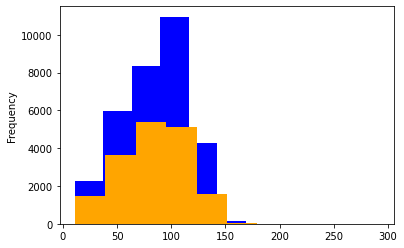

In [12]:
# checking the distribution of tweets in the data

length_train = train['tweet'].str.len().plot.hist(color = 'blue', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

In [13]:
# adding a column to represent the length of the tweet

train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

train.head(10)

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39
5,6,0,[2/2] huge fan fare and big talking before the...,116
6,7,0,@user camping tomorrow @user @user @user @use...,74
7,8,0,the next school year is the year for exams.ð...,143
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,87
9,10,0,@user @user welcome here ! i'm it's so #gr...,50


In [14]:

train.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                    len                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0

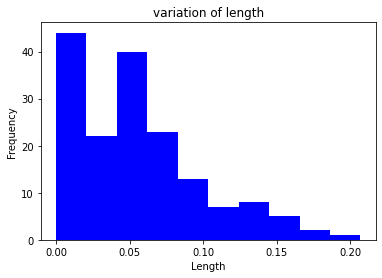

In [15]:
train.groupby('len').mean()['label'].plot.hist(color = 'blue', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

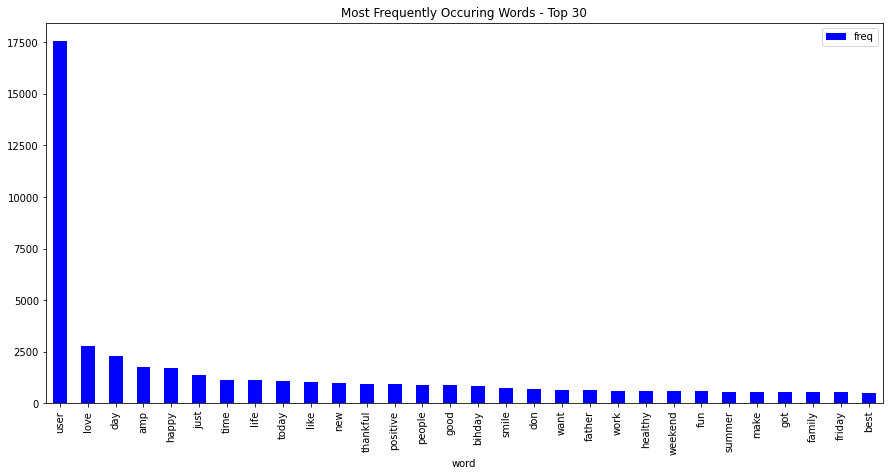

In [16]:
#CountVectorizer is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. 
#This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors 
#(for using in further text analysis)

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

#Displaying the top 30 frequently used word from the train dataset


Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

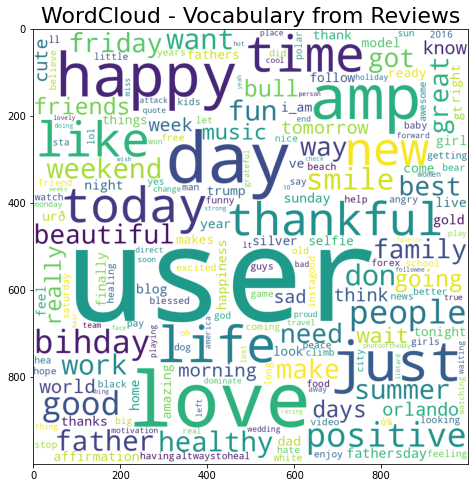

In [17]:
#wordcloud is Significant textual data points can be highlighted using a word cloud. 
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

#Displays the most frequently words according to the weight 

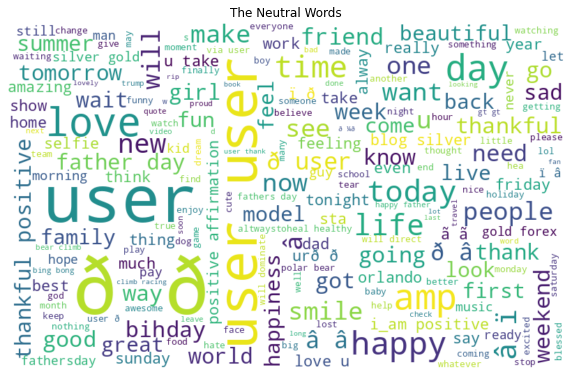

In [18]:
normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(background_color = 'white',width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()


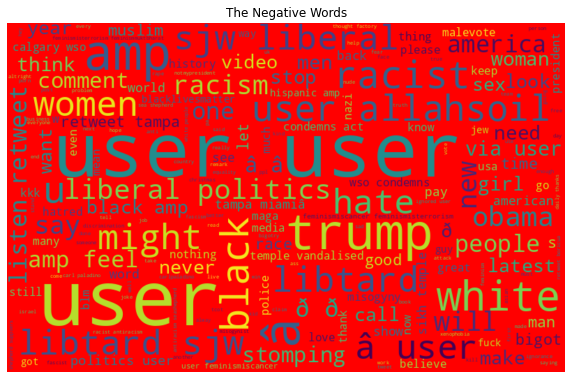

In [19]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(background_color = 'red', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()


In [20]:
# collecting the hashtags
import re
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [21]:
# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(train['tweet'][train['label'] == 0])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_regular

['run',
 'lyft',
 'disapointed',
 'getthanked',
 'model',
 'motivation',
 'allshowandnogo',
 'school',
 'exams',
 'hate',
 'imagine',
 'actorslife',
 'revolutionschool',
 'girl',
 'allin',
 'cavs',
 'champions',
 'cleveland',
 'clevelandcavaliers',
 'gr8',
 'ireland',
 'blog',
 'silver',
 'gold',
 'forex',
 'orlando',
 'standwithorlando',
 'pulseshooting',
 'orlandoshooting',
 'biggerproblems',
 'selfish',
 'heabreaking',
 'values',
 'love',
 '80days',
 'gettingfed',
 'got7',
 'junior',
 'yugyoem',
 'omg',
 'thankful',
 'positive',
 'friday',
 'cookies',
 'euro2016',
 'badday',
 'coneofshame',
 'cats',
 'pissed',
 'funny',
 'laughs',
 'wine',
 'weekend',
 'tgif',
 'ff',
 'gamedev',
 'indiedev',
 'indiegamedev',
 'squad',
 'upsideofflorida',
 'shopalyssas',
 'love',
 'smiles',
 'media',
 'pressconference',
 'antalya',
 'turkey',
 'throwback',
 'ica16',
 'rip',
 'orlando',
 'alohafriday',
 'time',
 'not',
 'exist',
 'positivevibes',
 'hawaiian',
 'goodnight',
 'badmonday',
 'taylorswift1

In [22]:
# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])
HT_negative = sum(HT_negative,[])
HT_negative

['cnn',
 'michigan',
 'tcot',
 'australia',
 'opkillingbay',
 'seashepherd',
 'helpcovedolphins',
 'thecove',
 'helpcovedolphins',
 'neverump',
 'xenophobia',
 'love',
 'peace',
 'race',
 'identity',
 'medâ',
 'altright',
 'whitesupremacy',
 'linguistics',
 'race',
 'power',
 'raciolinguistics',
 'brexit',
 'people',
 'trump',
 'republican',
 'michelleobama',
 'knicks',
 'golfâ',
 'jewishsupremacist',
 'libtard',
 'sjw',
 'liberal',
 'politics',
 'trash',
 'hate',
 'â',
 'stereotyping',
 'prejudice',
 'hope',
 'hate',
 'conflictâ',
 'pols',
 'bluelivesmatter',
 'draintheswamp',
 'ferguson',
 '2016',
 'antisemitism',
 'hocoschools',
 'columbiamd',
 'hocomd',
 'nazi',
 'hatred',
 'bigotry',
 'libtard',
 'sjw',
 'liberal',
 'politics',
 'p2',
 'p21',
 'fyi',
 'tcot',
 'topoli',
 'blacklivesmatter',
 'ushistory',
 'eugenics',
 'biherism',
 'bigotry',
 'altright',
 'potus',
 'theresistance',
 'crime',
 'officerâ',
 'black',
 'retweet',
 'tampa',
 'miamiâ',
 'allahsoil',
 'praised',
 'clevel

In [23]:
import nltk
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
list(a.keys())

['run',
 'lyft',
 'disapointed',
 'getthanked',
 'model',
 'motivation',
 'allshowandnogo',
 'school',
 'exams',
 'hate',
 'imagine',
 'actorslife',
 'revolutionschool',
 'girl',
 'allin',
 'cavs',
 'champions',
 'cleveland',
 'clevelandcavaliers',
 'gr8',
 'ireland',
 'blog',
 'silver',
 'gold',
 'forex',
 'orlando',
 'standwithorlando',
 'pulseshooting',
 'orlandoshooting',
 'biggerproblems',
 'selfish',
 'heabreaking',
 'values',
 'love',
 '80days',
 'gettingfed',
 'got7',
 'junior',
 'yugyoem',
 'omg',
 'thankful',
 'positive',
 'friday',
 'cookies',
 'euro2016',
 'badday',
 'coneofshame',
 'cats',
 'pissed',
 'funny',
 'laughs',
 'wine',
 'weekend',
 'tgif',
 'ff',
 'gamedev',
 'indiedev',
 'indiegamedev',
 'squad',
 'upsideofflorida',
 'shopalyssas',
 'smiles',
 'media',
 'pressconference',
 'antalya',
 'turkey',
 'throwback',
 'ica16',
 'rip',
 'alohafriday',
 'time',
 'not',
 'exist',
 'positivevibes',
 'hawaiian',
 'goodnight',
 'badmonday',
 'taylorswift1989',
 'travelingram'

In [24]:
list(a.values())

[33,
 2,
 1,
 2,
 364,
 166,
 1,
 24,
 6,
 24,
 3,
 8,
 1,
 166,
 2,
 11,
 4,
 9,
 1,
 1,
 18,
 345,
 299,
 298,
 265,
 235,
 2,
 11,
 59,
 1,
 3,
 14,
 4,
 1531,
 1,
 1,
 2,
 1,
 1,
 26,
 491,
 874,
 225,
 5,
 129,
 5,
 1,
 26,
 11,
 140,
 3,
 28,
 265,
 77,
 39,
 30,
 25,
 17,
 27,
 7,
 10,
 59,
 18,
 1,
 1,
 13,
 20,
 2,
 91,
 4,
 43,
 11,
 3,
 30,
 4,
 28,
 1,
 4,
 3,
 1,
 2,
 3,
 2,
 1,
 1,
 2,
 3,
 1,
 69,
 7,
 9,
 1,
 16,
 3,
 1,
 352,
 363,
 2,
 2,
 9,
 15,
 2,
 2,
 89,
 278,
 2,
 10,
 1,
 2,
 114,
 32,
 71,
 254,
 1,
 61,
 3,
 7,
 6,
 144,
 3,
 51,
 2,
 255,
 17,
 17,
 49,
 153,
 75,
 1,
 3,
 25,
 3,
 1,
 7,
 4,
 1,
 125,
 5,
 2,
 2,
 11,
 8,
 12,
 3,
 1,
 9,
 84,
 53,
 13,
 21,
 2,
 1,
 25,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 29,
 295,
 570,
 168,
 5,
 11,
 4,
 15,
 24,
 34,
 6,
 1,
 50,
 27,
 12,
 18,
 30,
 3,
 1,
 67,
 108,
 122,
 434,
 1,
 1,
 33,
 1,
 1,
 1,
 1,
 2,
 2,
 73,
 3,
 27,
 16,
 156,
 1,
 6,
 13,
 3,
 6,
 46,
 5,
 58,
 1,
 1,
 5,
 152,
 29,
 213,
 548,
 1,
 29,
 1

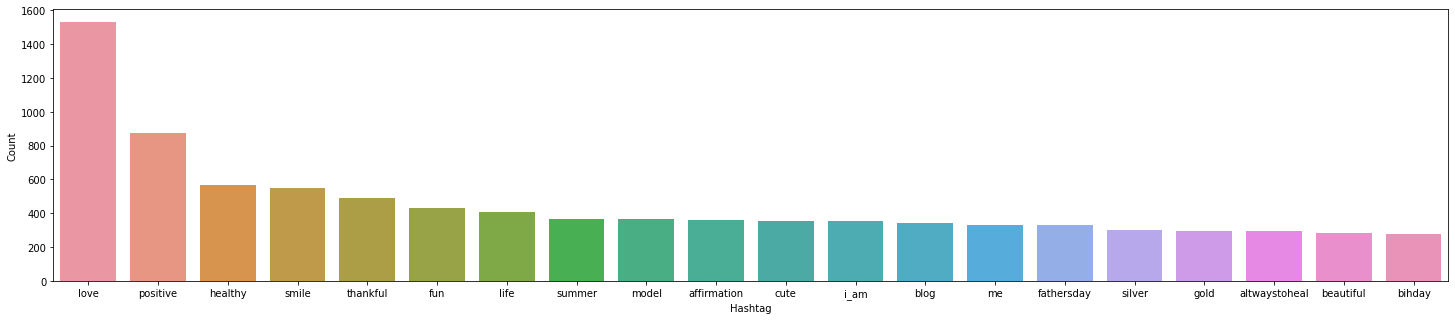

In [25]:
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(25,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [26]:
#gensim - The fastest library for training of vector embeddings 

import gensim

tokenized_tweet = train['tweet'].apply(lambda x: x.split()) 
tokenized_tweet

0        [@user, when, a, father, is, dysfunctional, an...
1        [@user, @user, thanks, for, #lyft, credit, i, ...
2                                  [bihday, your, majesty]
3        [#model, i, love, u, take, with, u, all, the, ...
4                 [factsguide:, society, now, #motivation]
                               ...                        
31957    [ate, @user, isz, that, youuu?ðððð...
31958    [to, see, nina, turner, on, the, airwaves, try...
31959    [listening, to, sad, songs, on, a, monday, mor...
31960    [@user, #sikh, #temple, vandalised, in, in, #c...
31961                [thank, you, @user, for, you, follow]
Name: tweet, Length: 31962, dtype: object

In [27]:
# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tweet']), epochs=20)

(6109318, 8411580)

In [28]:
model_w2v.wv.most_similar(positive = "dinner")

[('spaghetti', 0.6342835426330566),
 ('#prosecco', 0.6073246002197266),
 ('podium', 0.5819236040115356),
 ('sister!!', 0.5815128684043884),
 ('enroute', 0.5803096294403076),
 ('#westend', 0.5799866318702698),
 ('#trailrunning', 0.5799092650413513),
 ('dining', 0.5781534314155579),
 ('#travelling', 0.5757690668106079),
 ('#burgers', 0.5749226808547974)]

In [29]:
model_w2v.wv.most_similar(negative = "dinner")

[('#london', -0.03542696684598923),
 ('#studio', -0.044508446007966995),
 ('#wednesdaywisdom', -0.049839556217193604),
 ('#hype', -0.05706586688756943),
 ('#green', -0.06395615637302399),
 ('#fundraising', -0.06656564027070999),
 ('#traveling', -0.06682100892066956),
 ('#football', -0.07293757796287537),
 ('seeks', -0.07445254921913147),
 ('#games', -0.07514926791191101)]

In [30]:
model_w2v.wv.most_similar(negative = "missyou")

[('#wednesdaywisdom', -0.033185072243213654),
 ('huge', -0.0563168004155159),
 ('#cycling', -0.06378929316997528),
 ('#fundraising', -0.06778548657894135),
 ('games', -0.07106350362300873),
 ('final', -0.08162945508956909),
 ('ð\x9f\x98\x81', -0.08554676175117493),
 ('current', -0.08912605047225952),
 ('tips', -0.09208612143993378),
 ('#games', -0.0922296792268753)]

In [31]:
model_w2v.wv.most_similar(positive = "missyou")
#The word is not in the positive vocabulary

KeyError: ignored

In [32]:
model_w2v.wv.most_similar(positive = "apple")

[('"mytraining"', 0.7011239528656006),
 ('mytraining', 0.6882128715515137),
 ('training"', 0.6821887493133545),
 ('app,', 0.6298081278800964),
 ('app', 0.6147879362106323),
 ('ta', 0.5963596105575562),
 ('"my', 0.5824772715568542),
 ('#ilovegin', 0.5661935806274414),
 ('heroku', 0.5642464756965637),
 ('#appleta', 0.563538670539856)]

In [33]:
model_w2v.wv.most_similar(negative = "apple")

[('#apple', 0.02554575353860855),
 ('seeks', -0.023540573194622993),
 ('#fundraising', -0.023585844784975052),
 ('#charity', -0.026315411552786827),
 ('#hype', -0.028092745691537857),
 ('current', -0.035759735852479935),
 ('season', -0.035804376006126404),
 ('#wwdc2016', -0.03803181275725365),
 ('#wednesdaywisdom', -0.04785614088177681),
 ('game', -0.05025633051991463)]

In [34]:
model_w2v.wv.most_similar(positive = "bihday")

[('ð\x9f\x8e\x82', 0.6244034767150879),
 ('bday', 0.6052944660186768),
 ('#bihday', 0.582137942314148),
 ('#johnnydepp', 0.5615200400352478),
 ('yul', 0.5513039827346802),
 ('tu', 0.544215977191925),
 ('bihday!', 0.5392797589302063),
 ('bihdayé\x87\x8eæ\x9b¿æ\x84\x81å¹³', 0.5338130593299866),
 ('bihdaykazuki', 0.5258954167366028),
 ('#chrisevans', 0.524093747138977)]

In [35]:
model_w2v.wv.most_similar(negative = "motivation")

[('#fundraising', -0.03815195709466934),
 ('#wednesdaywisdom', -0.04610133543610573),
 ('#australia', -0.06667833030223846),
 ('#apple', -0.07606662809848785),
 ('#teeth', -0.08439517021179199),
 ('here', -0.09221591055393219),
 ('link', -0.09422538429498672),
 ('#fl', -0.09906114637851715),
 ('#games', -0.09945698082447052),
 ('us.', -0.09959936141967773)]

In [36]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

In [37]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

<ipython-input-37-c4d4182b25a0>:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))


[LabeledSentence(words=['@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction.', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['@user', '@user', 'thanks', 'for', '#lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx.', '#disapointed', '#getthanked'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'i', 'love', 'u', 'take', 'with', 'u', 'all', 'the', 'time', 'in', 'urð\x9f\x93±!!!', 'ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91', 'ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'], tags=['tweet_3']),
 LabeledSentence(words=['factsguide:', 'society', 'now', '#motivation'], tags=['tweet_4']),
 LabeledSentence(words=['[2/2]', 'huge', 'fan', 'fare', 'and', 'big', 'talking', 'before', 'they', 'leave.', 'chaos', 'and', 'pay', 'disputes', 'when', 'they', 'get', 'there.', '#allshowandn

In [ ]:
# removing unwanted patterns from the data

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


In [43]:
train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

In [ ]:
train_corpus

In [ ]:
test_corpus = []

for i in range(0, 17197):
  review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
  # stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)

In [44]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)


(31962, 2500)
(31962,)


In [45]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)


(17197, 2500)


In [46]:
# splitting the training data into train and valid sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23971, 2500)
(7991, 2500)
(23971,)
(7991,)


# Feature Scaling

In [47]:
# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)


# RandomForestClassifier Model

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)



Training Accuracy : 0.999123941429227
Validation Accuracy : 0.9529470654486297
F1 score : 0.6186612576064908
[[7310  122]
 [ 254  305]]


# Logistic Regression Model

In [49]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy : 0.9851487213716574
Validation Accuracy : 0.9416843949443123
f1 score : 0.5933682373472949
[[7185  247]
 [ 219  340]]


# DecisionTreeClassifier Model

In [50]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)


Training Accuracy : 0.9991656585040257
Validation Accuracy : 0.9319234138405706
f1 score : 0.5326460481099655
[[7137  295]
 [ 249  310]]


# SVC Model

In [ ]:
from sklearn.svm import SVC

model = SVC()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)


# XGBClassifier Model

In [51]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9603687789412206
Validation Accuracy : 0.9555750218996371
f1 score : 0.5748502994011976
[[7396   36]
 [ 319  240]]


# Conclusion


Among many models used to predict, the RandomForestClassifier is the model with highest accuracy and f1 score. Hence its the best suited model.
